# VOPY


```
%% Setup
ds = 2; % 0: KITTI, 1: Malaga, 2: parking

% Path containing images, depths and all...
last_frame = 598;
K = load([parking_path '/K.txt']);
ground_truth = load([parking_path '/poses.txt']);
ground_truth = ground_truth(:, [end-8 end]);

img0 = rgb2gray(imread([parking_path ...
    sprintf('/images/img_%05d.png',bootstrap_frames(1))]));
img1 = rgb2gray(imread([parking_path ...
    sprintf('/images/img_%05d.png',bootstrap_frames(2))]));

%% Continuous operation
range = (bootstrap_frames(2)+1):last_frame;
for i = range
    fprintf('\n\nProcessing frame %d\n=====================\n', i);
    image = im2uint8(rgb2gray(imread([parking_path ...
        sprintf('/images/img_%05d.png',i)])));
    % Makes sure that plots refresh.    
    pause(0.01);
    prev_img = image;
end
```

In [1]:
# Get the data
!cd .. && sh get-data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198M  100  198M    0     0   102M      0  0:00:01  0:00:01 --:--:--  102M


In [148]:
# Import libraries
import numpy as np
from os import path
import skimage as ski
import skimage.io as skio
from skimage import transform
from scipy import signal
import matplotlib.pyplot as plt

In [155]:
# Define constants
DATASET_PATH = "../data/parking"
LAST_FRAME = 598
IMAGE_RATIO = 0.5

In [156]:
def load_dataset(dataset_path):
    ground_truth = np.loadtxt(path.join(dataset_path, "poses.txt"))   
    K = np.loadtxt(path.join(dataset_path, "K.txt"))

    def load_image(frame):
        im_path = path.join(dataset_path, "images", "img_%05d.png" % frame)
        full_image = skio.imread(im_path, as_gray=True)
        return ski.transform.rescale(full_image, IMAGE_RATIO)
    return load_image, ground_truth, K


get_image, ground_truth, K = load_dataset(DATASET_PATH)

In [157]:
ground_truth

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [158]:
K

array([[331.37 ,   0.   , 320.   ],
       [  0.   , 369.568, 240.   ],
       [  0.   ,   0.   ,   1.   ]])

## Part 1 - Initialization

Estimate relative pose of the camera

### Select initial frames

In [159]:
# Manually select two frames at the beginning of the dataset
i0 = get_image(0)
i1 = get_image(16)

<IPython.core.display.Javascript object>


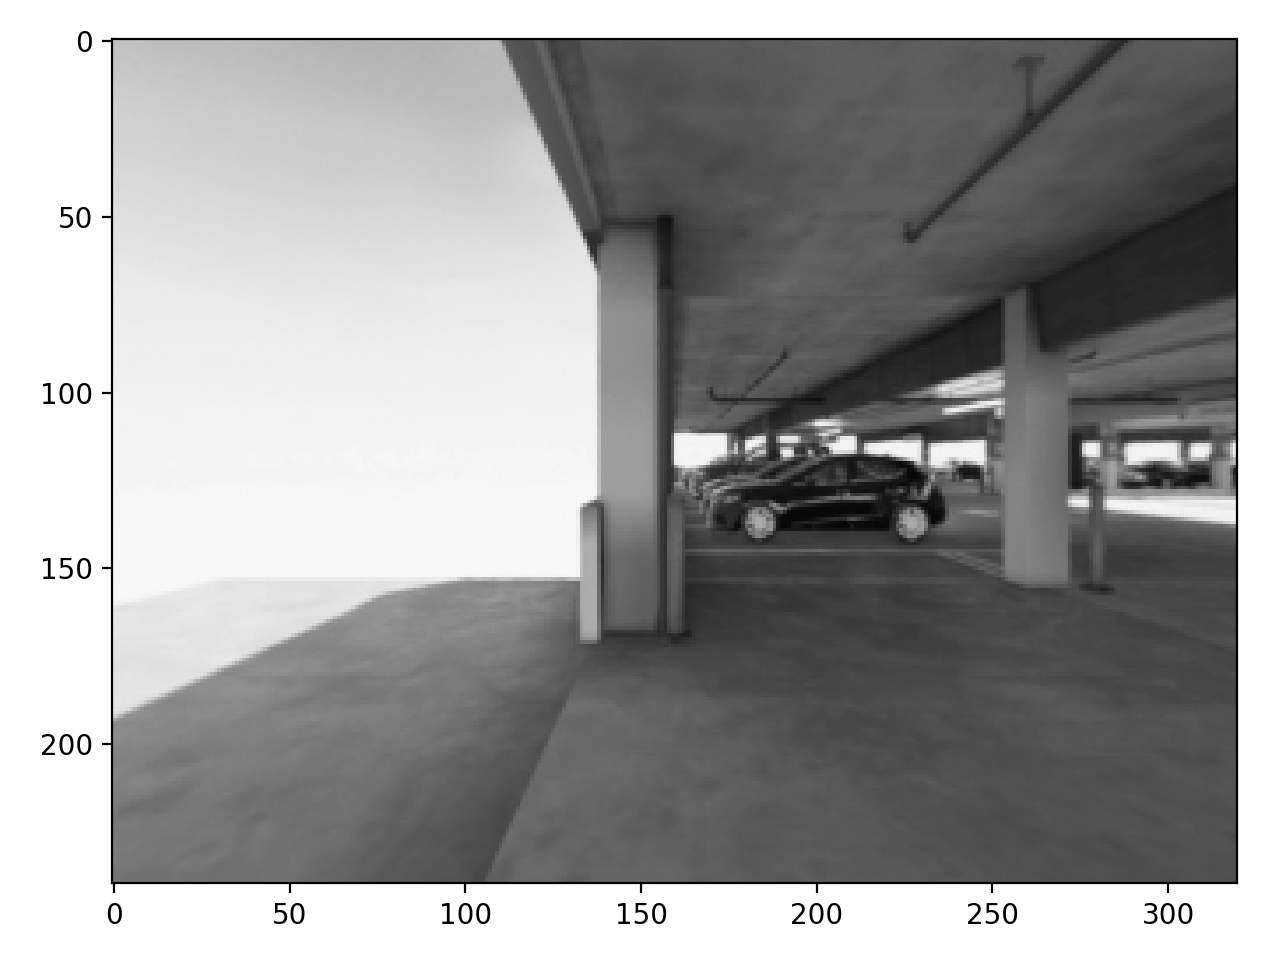

In [160]:
plt.figure()
skio.imshow(i0)

<IPython.core.display.Javascript object>


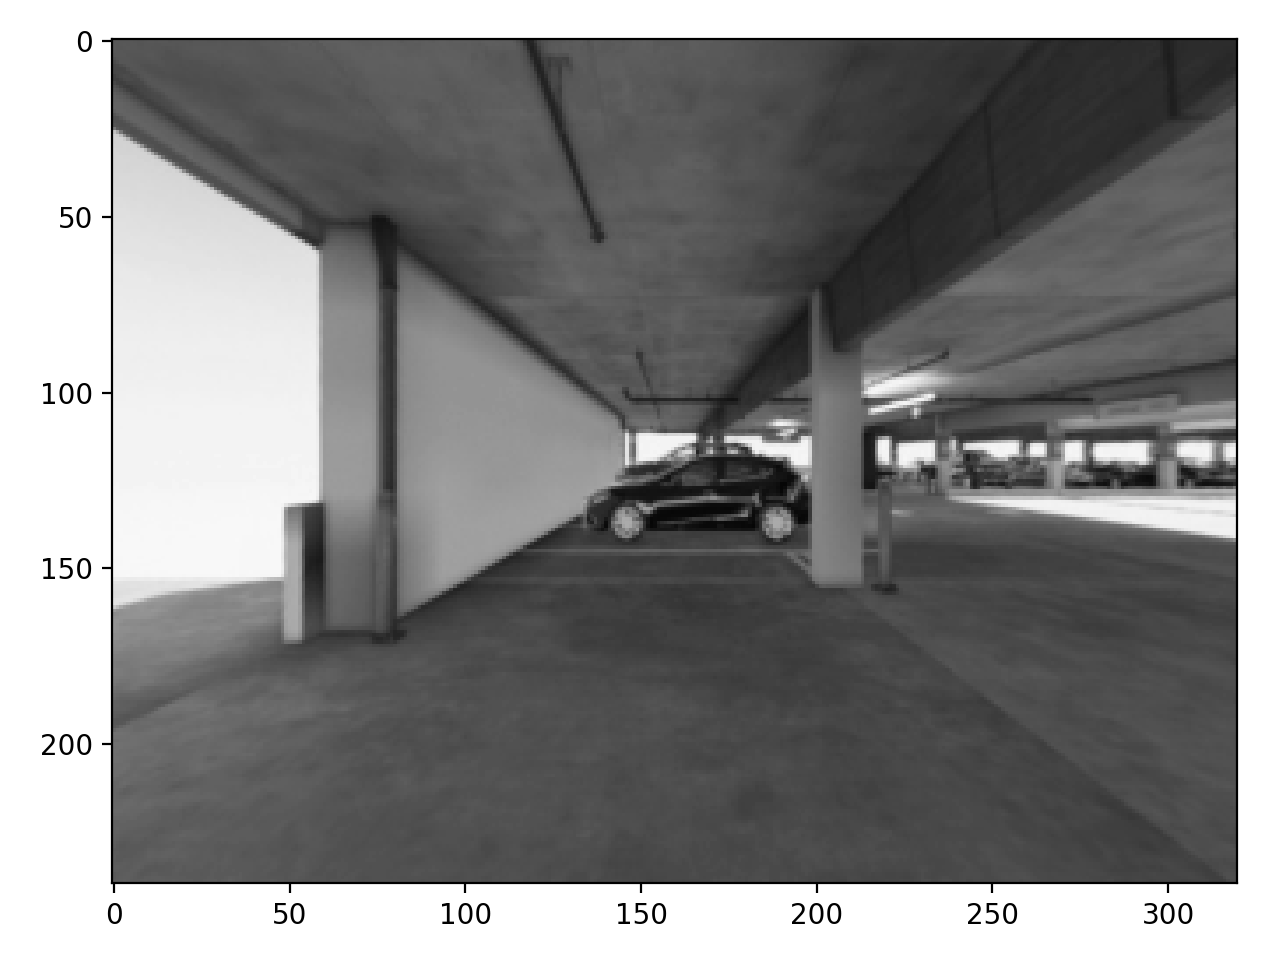

In [161]:
plt.figure()
skio.imshow(i1)

### Estabilish keypoint correspondences

In [162]:
# Parameters
patch_size = 9
kappa = 0.08
num_keypoints = 200
nonmaximum_supression_radius = 8
descriptor_radius = 9
match_lambda = 4

In [169]:
def harris(img):
    sobel_y = np.array([[-1, -2, -1],[0,0,0],[1,2,1]])
    sobel_x = sobel_y.T

    Ix = signal.convolve2d(sobel_x, img, 'valid')
    Iy = signal.convolve2d(sobel_y, img, 'valid')
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    patch = np.ones([patch_size, patch_size])
    pr = np.floor(patch_size / 2).astype(int)
    
    sIxx = signal.convolve2d(Ixx, patch, 'valid');
    sIyy = signal.convolve2d(Iyy, patch, 'valid');
    sIxy = signal.convolve2d(Ixy, patch, 'valid');

    scores = (sIxx * sIyy - sIxy ** 2) - kappa * (sIxx + sIyy) ** 2

    return np.pad(scores.clip(min=0), [1+pr, 1+pr]);

In [170]:
harris_score = harris(i0)

<IPython.core.display.Javascript object>


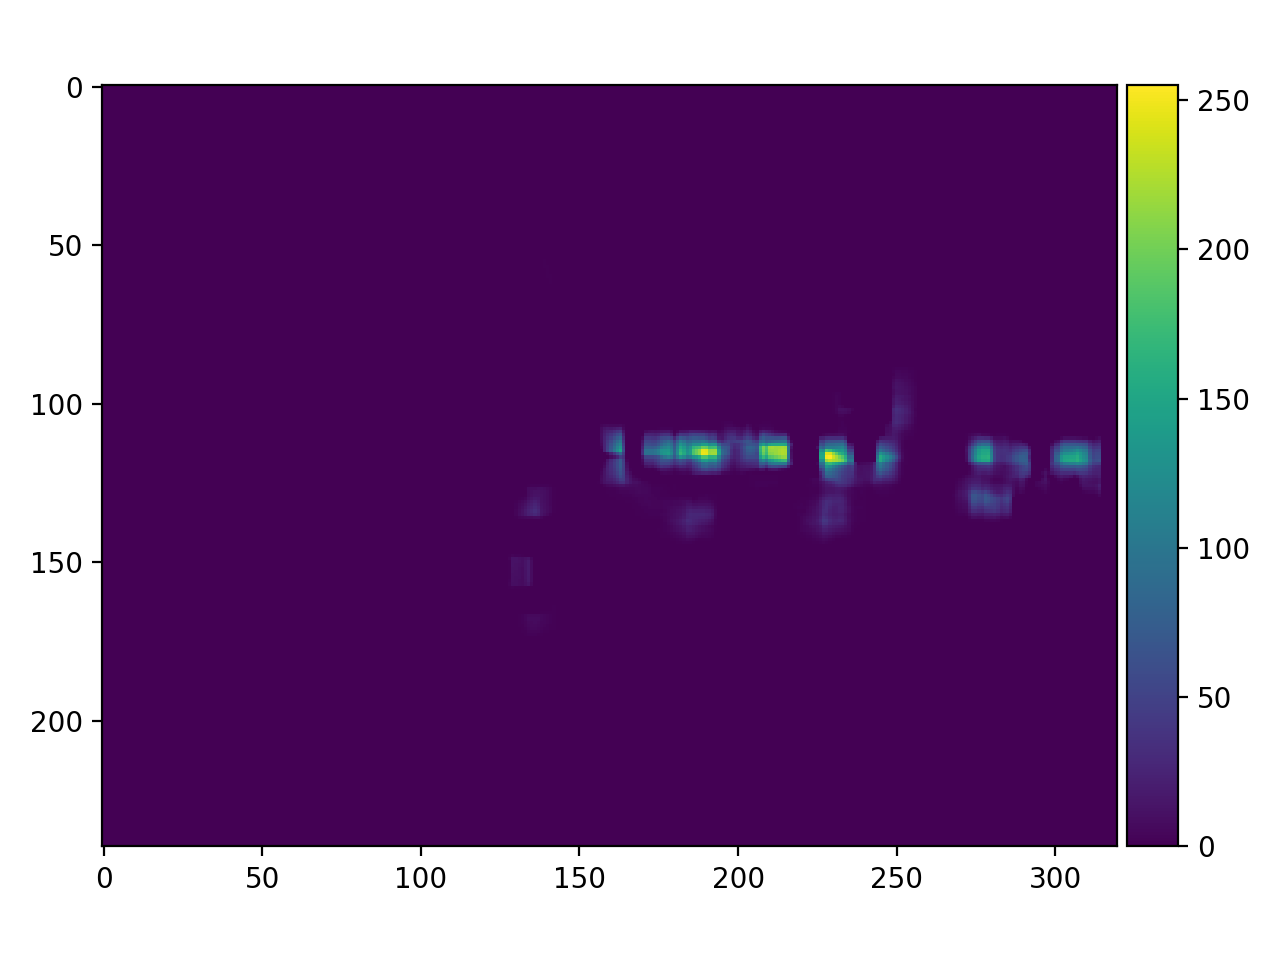

In [171]:
rescaled = harris_score * 255.0/harris_score.max() 
plt.figure()
skio.imshow(rescaled)

In [135]:
def select_keypoints(img):
    keypoints = zeros(2, num);
    temp_scores = padarray(scores, [r r]);
    for i = 1:num
        [~, kp] = max(temp_scores(:));
        [row, col] = ind2sub(size(temp_scores), kp);
        kp = [row;col];
        keypoints(:, i) = kp - r;
        temp_scores(kp(1)-r:kp(1)+r, kp(2)-r:kp(2)+r) = zeros(2*r + 1, 2*r + 1);

SyntaxError: invalid syntax (<ipython-input-135-e394c7b18e55>, line 3)

array([[1., 1.]])